In [6]:
import os
import sys
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to load operation ini.
No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to load operation ini.
No vtk
No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to load operation ini.
Seems you are using operation INIs to provide cropbox.
No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to load operation ini.
Seems you are using operation INIs to provide cropbox.


This tutorial walks you through the demo suite.

# Preprocess

First we download the JP2 raw images

In [ ]:
! download_demo_data_preprocessing.py

Create `DEMO998_input_spec.json`. This specifies where to find each version/resolution of the raw image files.

In [ ]:
%%writefile DEMO998_input_spec.json
[
    {"version": null, 
 "resolution": "raw", 
     "data_dirs": "/home/yuncong/MouseBrainAtlas/demo/demo_data/jp2_files/DEMO998/", 
     "filepath_to_imageName_mapping": "/home/yuncong/MouseBrainAtlas/demo/demo_data/jp2_files/DEMO998/(.*)?_lossless.jp2", 
     "imageName_to_filepath_mapping": "/home/yuncong/MouseBrainAtlas/demo/demo_data/jp2_files/DEMO998/%s_lossless.jp2"
    }
]

Convert all JPEG2000 files to TIF files (16-bit).

In [ ]:
! python jp2_to_tiff.py DEMO998 DEMO998_input_spec.json

DEMO998 is a fluorescently stained stack. The texture information is mainly in the Neurotrace-blue stain which is scanned as the blue channel.

We use the `extract_channel.py` script to extract the blue channel of the images. 
- first create a `input_spec.ini` to describe the input where the prep_id/version/resolution are set to `(None,None,raw)`.
- give the resulting __version__ a name "Ntb".

In [ ]:
%%writefile input_spec.ini
[DEFAULT]
image_name_list = MD662&661-F81-2017.06.06-12.44.40_MD661_2_0242
    MD662&661-F84-2017.06.06-14.03.51_MD661_1_0250
    MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257
stack = DEMO998
prep_id = None
version = None
resol = raw

In [ ]:
! python extract_channel.py input_spec.ini 2 Ntb

Since raw images (roughly 30,000 by 30,000 pixels) are cumbersome to examine.
We also generate smaller thumbnails by scaling 32 times down. 1/32=0.03125.
- Create `input_spec.ini` as (None,Ntb,raw).
- Call the new __resolution__ "thumbnail".

In [ ]:
%%writefile input_spec.ini
[DEFAULT]
image_name_list = MD662&661-F81-2017.06.06-12.44.40_MD661_2_0242
    MD662&661-F84-2017.06.06-14.03.51_MD661_1_0250
    MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257
stack = DEMO998
prep_id = None
version = Ntb
resol = raw

In [ ]:
! python rescale.py input_spec.ini thumbnail -f 0.03125

Let's see an example thumbnail image.

In [9]:
img_fp = DataManager.get_image_filepath_v2(stack='DEMO998', resol='thumbnail', prep_id=None, version='Ntb', 
                                  fn='MD662&661-F84-2017.06.06-14.03.51_MD661_1_0250')

In [16]:
img = imread(img_fp)
print img.dtype

uint16


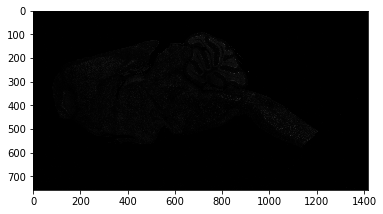

In [15]:
plt.imshow(img, cmap=plt.cm.gray);

The image is very dim because most pixel intensities are concentrated at the bottom part of the 0-2^15 range.
To enhance the contrast, we stretch the histogram so that the entire available intensity range is utilized.
- Create input_spec.ini as (None,Ntb,thumbnail). 
- call the resulting version "NtbNormalized". Note that this is just a global linear histogram stretching - not to be confused with the local adaptive intensity correction that we will do later.

In [ ]:
%%writefile input_spec.ini
[DEFAULT]
image_name_list = MD662&661-F81-2017.06.06-12.44.40_MD661_2_0242
    MD662&661-F84-2017.06.06-14.03.51_MD661_1_0250
    MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257
stack = DEMO998
prep_id = None
version = Ntb
resol = thumbnail

In [ ]:
! python normalize_intensity.py input_spec.ini NtbNormalized

Let's see a resulting image

In [18]:
img_fp = DataManager.get_image_filepath_v2(stack='DEMO998', resol='thumbnail', prep_id=None, version='NtbNormalized', 
                                  fn='MD662&661-F84-2017.06.06-14.03.51_MD661_1_0250')

In [19]:
img = imread(img_fp)
print img.dtype

uint8


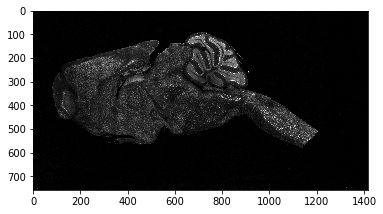

In [20]:
plt.imshow(img, cmap=plt.cm.gray);

Now the tissues are much easier to see. Note that the normalized images are now 8-bit.